<a href="https://colab.research.google.com/github/SiyiTang/LearningProcess/blob/main/MyPortfolio-2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install deepdow

     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 14.2MB 227kB/s 
     |████████████████████████████████| 2.2MB 48.5MB/s 
     |████████████████████████████████| 1.3MB 44.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 1.1MB 45.5MB/s 
     |████████████████████████████████| 153kB 56.8MB/s 
     |████████████████████████████████| 163kB 49.5MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
  Created wheel for cvxpy: filename=cvxpy-1.1.12-cp37-cp37m-linux_x86_64.whl size=2731683 sha256=a2818a1198363959a23578a0f6fcde9da26ff4c13e10bf9be7cadbf04c1aa936
  Stored in directory: /root/.cache/pip/wheels/9b/

# Imports and Configuration

In [2]:
%matplotlib inline
from deepdow.benchmarks import Benchmark, OneOverN, Random, Singleton
from deepdow.callbacks import EarlyStoppingCallback, TensorBoardCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.experiments import Run
from deepdow.nn import KeynesNet
from deepdow.layers import (AttentionCollapse, AverageCollapse, CovarianceMatrix, Conv, NumericalMarkowitz, MultiplyByConstant,
                     RNN, SoftmaxAllocator, WeightNorm)
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.utils import raw_to_Xy
import matplotlib.pyplot as plt
import numpy as np
import torch
import datetime
import pandas as pd
import pandas_datareader.data as web

# Initialize

In [3]:
# 获取默认图形尺寸
default_figsize = plt.rcParams["figure.figsize"]

In [4]:
# set random seed for repeatility
torch.manual_seed(4)
np.random.seed(5)

# Data Preprocess

In [5]:
# set start and end time
start = datetime.datetime(2009, 1, 1) 
end = datetime.datetime(2019, 12, 31)

tickers = ['AAPL','NFLX','AMZN','KO']
# fetch close price
raw_df = web.DataReader(tickers, 'yahoo', start=start, end=end)[['Close']]

In [6]:
# Re-structure the columns
raw_df.columns = pd.MultiIndex.from_product([tickers, ["Close"]], names=["Ticker", "Attribute"]
)
assert isinstance(raw_df, pd.DataFrame)
assert isinstance(raw_df.index, pd.DatetimeIndex)
assert isinstance(raw_df.columns, pd.MultiIndex)
raw_df.head()

Ticker,AAPL,NFLX,AMZN,KO
Attribute,Close,Close,Close,Close
Date,,,,
2009-01-02,3.241071,4.267143,54.360001,22.950001
2009-01-05,3.377857,4.562857,54.060001,22.719999
2009-01-06,3.322143,4.705714,57.360001,22.355000
2009-01-07,3.250357,4.672857,56.200001,22.465000
2009-01-08,3.310714,4.735714,57.160000,22.620001


Fill in with pandas-defined business days since that's used in DeepDow. Use ffill and bfill to copy the previous/next day's closing price assuming no change on days not provided from source.

Note: Chinese trading days are different than pandas business days

In [7]:
index = pd.date_range(start=raw_df.index[0], end=raw_df.index[-1], freq="B")

print(f"Num records before fill: {len(raw_df)}")
raw_df = pd.DataFrame(raw_df, index=index).ffill().bfill()
print(f"Num records after fill: {len(raw_df)}")

Num records before fill: 2768
Num records after fill: 2868


# Creat Database

Derive some parameters for use in creating datasets

In [8]:
n_timesteps = len(raw_df)
n_channels = len(raw_df.columns.levels[1])
n_assets = len(raw_df.columns.levels[0])

In [9]:
print('Timesteps = '+ str(n_timesteps))
print('Channels = '+ str(n_channels))
print('Assets = '+ str(n_assets))

Timesteps = 2868
Channels = 1
Assets = 4


In [10]:
lookback = 50  # Number of timesteps to look back, e.g. length of X in time
gap = 1  # Gap between end of X and start of y for each data sample
horizon = 5  # Number of timesteps to use for prediction

Generate the splits for train and test

In [11]:
X, timestamps, y, asset_names, indicators = raw_to_Xy(
    raw_df, lookback=lookback, gap=gap, freq="B", horizon=horizon
)

In [12]:
n_samples = n_timesteps - lookback - horizon - gap 
n_samples

2812

In [13]:
split_ix = int(n_samples * 0.9)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                             indices_test[0], indices_test[-1]))

Train range: 0:2529
Test range: 2585:2811


Convert `Xy` format to `InRAMDDataset` for loadin during training.

In [14]:
dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

X_sample, y_sample, timestamp_sample, asset_names = dataset[0]

Create a data loader for training from the dataset: 
* one for train
* one for test

In [15]:
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=64)

dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=64)

Print a sample to get acquainted with the format

In [16]:
X_batch, y_batch, timestamps_batch, asset_names_batch = next(iter(dataloader_test))
print(f"X_batch shape: {X_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")
print(f"Asset names: {asset_names_batch}")
print(f"Num Timestamps: {len(timestamps_batch)}, sample: {timestamps_batch[0]}")

X_batch shape: torch.Size([64, 1, 50, 4])
y_batch shape: torch.Size([64, 1, 5, 4])
Asset names: ['AAPL', 'AMZN', 'KO', 'NFLX']
Num Timestamps: 64, sample: 2019-03-14 00:00:00


In [17]:
loaders = {"train": dataloader_train, "test": dataloader_test}
date_ranges = {}
for label, d in loaders.items():
    minval = pd.Timestamp("2100-01-01 00:00:00", freq="B")
    maxval = pd.Timestamp("1970-01-01 00:00:00", freq="B")
    for _,_,c,_ in d:
        if min(c) < minval:
            minval = min(c)
        if max(c) > maxval:
            maxval = max(c)        
    date_ranges[label] = (minval, maxval)
    
print("Date ranges for each dataset:\n")
print(*[f"{k}: {v}\n" for k,v in date_ranges.items()])

Date ranges for each dataset:

train: (Timestamp('2009-03-13 00:00:00', freq='B'), Timestamp('2018-11-22 00:00:00', freq='B'))
 test: (Timestamp('2019-02-08 00:00:00', freq='B'), Timestamp('2019-12-23 00:00:00', freq='B'))



# Creat Network

In [18]:
class GreatNet(torch.nn.Module, Benchmark):

    def __init__(self, n_input_channels, hidden_size=32, transform_type='RNN', n_groups=4,  n_layers=1):
        self._hparams = locals().copy()
        super().__init__()

        self.transform_type = transform_type

        if self.transform_type == 'RNN':
            self.transform_layer = RNN(n_input_channels, hidden_size=hidden_size, bidirectional=False,
                                       cell_type='LSTM', n_layers=n_layers)

        elif self.transform_type == 'Conv':
            self.transform_layer = Conv(n_input_channels, n_output_channels=hidden_size, method='1D',
                                        kernel_size=3)

        else:
            raise ValueError('Unsupported transform_type: {}'.format(transform_type))

        if hidden_size % n_groups != 0:
            raise ValueError('The hidden_size needs to be divisible by the n_groups.')

        self.norm_layer_1 = torch.nn.InstanceNorm2d(n_input_channels, affine=True)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)
        self.norm_layer_2 = torch.nn.GroupNorm(n_groups, hidden_size, affine=True)
        self.time_collapse_layer = AverageCollapse(collapse_dim=2)
        self.channel_collapse_layer = AverageCollapse(collapse_dim=1)

        self.portfolio_opt_layer = SoftmaxAllocator(temperature=None)

    def __call__(self, x):
        """Perform forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, n_channels, lookback, n_assets).
        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).
        """
        n_samples, n_channels, lookback, n_assets = x.shape

        x = self.norm_layer_1(x)
        if self.transform_type == 'RNN':
            x = self.transform_layer(x)
        else:
            x = torch.stack([self.transform_layer(x[..., i]) for i in range(n_assets)], dim=-1)

        x = self.norm_layer_2(x)
        x = torch.nn.functional.relu(x)
        x = self.time_collapse_layer(x)
        x = self.channel_collapse_layer(x)

        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature

        weights = self.portfolio_opt_layer(x, temperatures)

        return weights

    @property
    def hparams(self):
        """Hyperparameters relevant to construction of the model."""
        return {k: v if isinstance(v, (int, float, str)) else str(v) for k, v in self._hparams.items() if k != 'self'}

In [19]:
network = GreatNet(n_input_channels=1,hidden_size=64,n_layers=2)
print(network)

GreatNet(
  (transform_layer): RNN(
    (cell): LSTM(1, 64, num_layers=2)
  )
  (norm_layer_1): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (norm_layer_2): GroupNorm(4, 64, eps=1e-05, affine=True)
  (time_collapse_layer): AverageCollapse()
  (channel_collapse_layer): AverageCollapse()
  (portfolio_opt_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


In [20]:
network = network.train()

In [21]:
loss =SharpeRatio()

In [22]:
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test,
                  'train': dataloader_train,},
          optimizer=torch.optim.Adam(network.parameters(),lr=0.0001,amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss', dataloader_name='test', patience=20)
                  ])

## Train the network

In [23]:
history = run.launch(100)

Epoch 48: 100%|██████████| 40/40 [00:55<00:00,  1.39s/it, loss=-0.18180, test_loss=-0.20681, train_loss=-0.18137]


Training interrupted
Training stopped early because there was no improvement in test_loss for 20 epochs


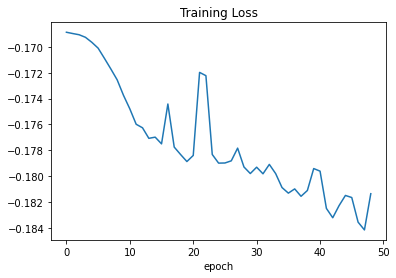

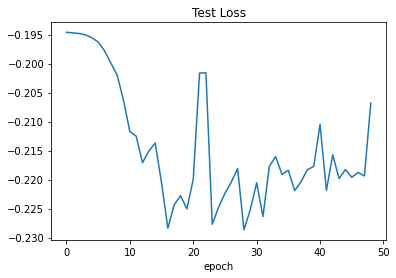

In [24]:
# Plot the training loss
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']
plt.figure()
per_epoch_results.mean()["train"]["loss"]["network"].plot(title="Training Loss")

# Plot the test loss
plt.figure()
per_epoch_results.mean()["test"]["loss"]["network"].plot(title="Test Loss")
#per_epoch_results.mean()['test']['loss']['network'].plot()

In [25]:
network = network.eval()

In [27]:
# Now add the others
benchmarks = {
    '1overN': OneOverN(),  # ogni titolo ha peso 1/n.titoli
    'random': Random(),  # allocazione randomica (simile a 1OverN)
    'network': network
}

# Include metrics. Selected two, since using only one bombs out at time of writing
# NOTE: We are using `simple` here for the mean return, whereas most of the training and data config above is in log-space by default.
metrics = {
    "Sharpe": SharpeRatio(),
    "MeanReturn": MeanReturns(output_type="simple"),
    "MaxDD": MaximumDrawdown(),
}


In [29]:
metrics_table = generate_metrics_table(benchmarks, dataloader_test, metrics)

In [30]:
metrics_table['value'] *= -1

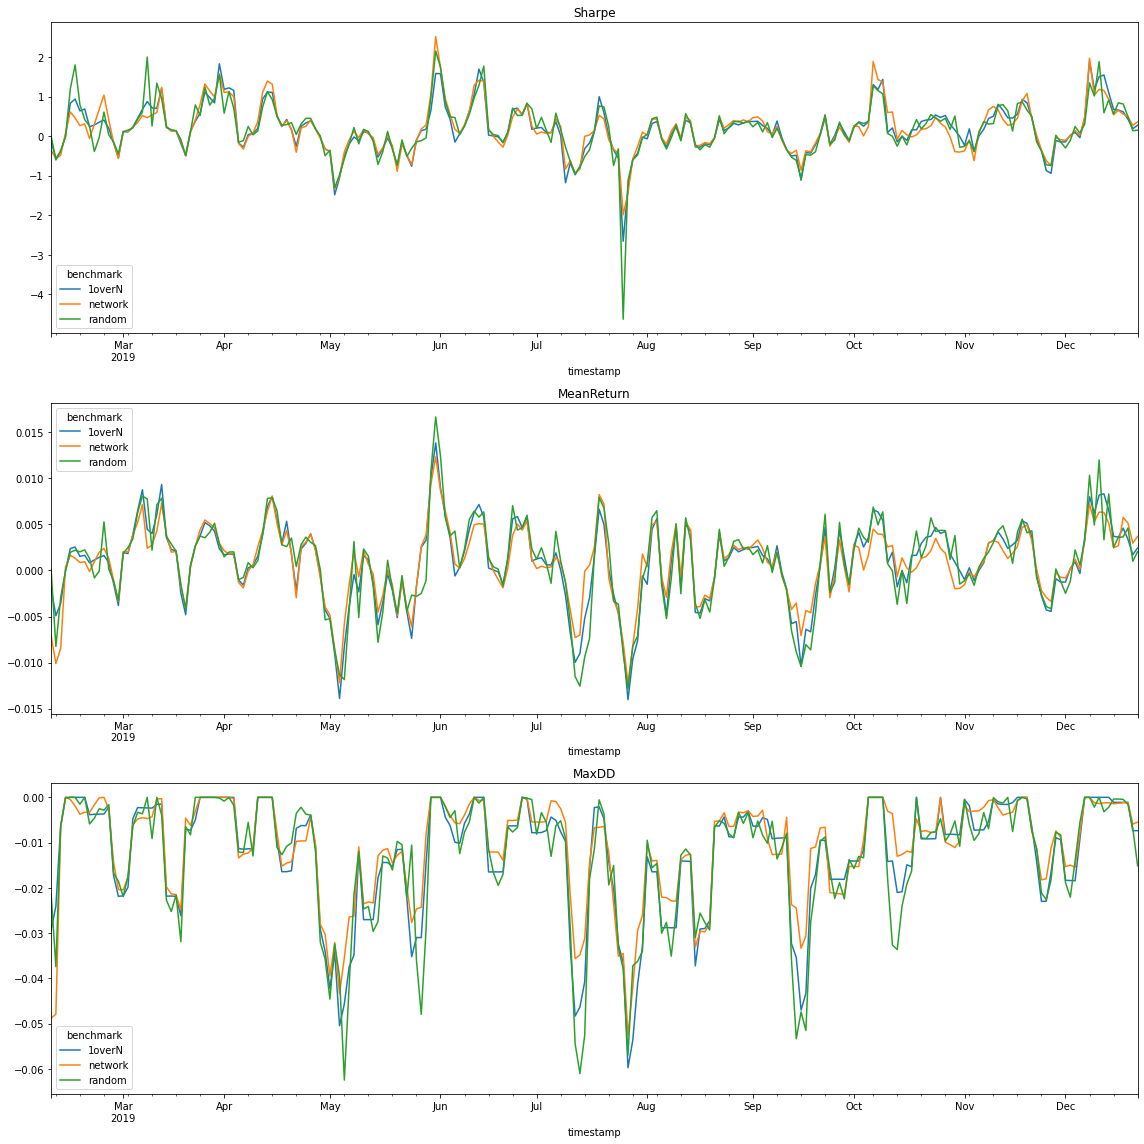

In [31]:
# Plot resulting metrics
# Note: this method doesn't accept a figure so we can't resize without assigning default figure size
plt.rcParams['figure.figsize'] = (16, 16)
plot_metrics(metrics_table)
plt.rcParams['figure.figsize'] = default_figsize

In [32]:
weight_table = generate_weights_table(network, dataloader_test)
weight_table

,AAPL,AMZN,KO,NFLX
2019-02-08,0.167765,0.166735,0.497674,0.167826
2019-02-11,0.161715,0.160946,0.514549,0.162790
2019-02-12,0.169206,0.170566,0.489623,0.170605
2019-02-13,0.169612,0.170980,0.488957,0.170451
2019-02-14,0.167390,0.166673,0.500053,0.165884
...,...,...,...,...
2019-12-17,0.225906,0.444322,0.176149,0.153623
2019-12-18,0.267232,0.397917,0.179085,0.155766
2019-12-19,0.281041,0.377821,0.184883,0.156255
2019-12-20,0.289509,0.344198,0.207673,0.158620


In [33]:
weight_table.to_csv('Portfolio_weight')

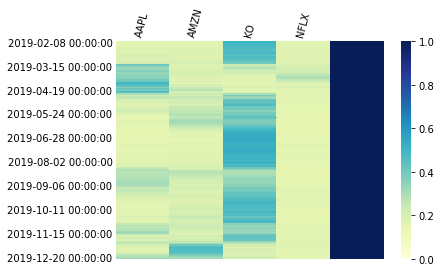

In [34]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

In [35]:
benchmarks = {asset_name: Singleton(asset_ix=i) for i, asset_name in enumerate(asset_names_batch)}
benchmarks["1overN"] = OneOverN()  # each asset has weight 1 / n_assets
benchmarks["random"] = Random()  # random allocation that is however close 1OverN
benchmarks["network"] = network  # our trained network

metrics_table2 = generate_metrics_table(benchmarks, dataloader_test, metrics)
metrics_table2['value'] *= -1
benchmark_num = metrics_table2['benchmark'].unique()
metric_num = metrics_table2['metric'].unique()

In [36]:
metrics_table2.to_csv('Portfolio_Metrics')

In [37]:
df2=pd.DataFrame(np.random.randn(len(benchmark_num),len(metric_num)),
                 index=list(benchmark_num),
                 columns=list(metric_num))

for i in benchmark_num:
  for j in metric_num:
    returns = metrics_table2.query(f"(metric=='{j}') & (benchmark == '{i}')")
    index_num=list(benchmark_num).index(i)
    column_num=list(metric_num).index(j)
    df2.iloc[index_num][column_num]=returns['value'].mean()
    #print(index_num,column_num,returns['value'].mean())
print(df2)




           Sharpe  MeanReturn     MaxDD
AAPL     0.291380    0.002447 -0.015314
AMZN     0.094403    0.000648 -0.015918
KO       0.139612    0.000670 -0.011534
NFLX     0.011912   -0.000141 -0.027585
1overN   0.194502    0.000909 -0.012654
random   0.202772    0.000915 -0.013044
network  0.206814    0.000905 -0.011077
